# Plotting communities

Communities are created in Neo4j using various communit detection algorithms. The results of these algorithms are stored in the database as a property of the nodes. This notebook shows how to plot these communities using the Neo4j graph algorithms library.

In [2]:
from pandas                 import DataFrame as df
from databaseconnection     import DatabaseConnection
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt

gds = DatabaseConnection().get_database_connection()
gds.version()


'2.3.2'

### Query data from Neo4j

First we need to connect to the Neo4j database and query the data we want to plot. The data will be stored in a pandas dataframe.

In [11]:
students = gds.run_cypher("MATCH (student:Student) RETURN student")["student"]

print("Number of students: ", len(students))
print(students)

# Convert the respondents Series to a DataFrame
students_data = []
for student in students:
    students_data.append({'id': student['id'], 'normalityIndex': student["normalityIndex"], 'louvainId_pos_prop': student["louvainId_pos_prop"],
                            'lpaId_pos_prop': student['lpaId_pos_prop'], 'wccId_pos_prop': student['wccId_pos_prop']})

students_df = df(students_data)

print(students_df)

Number of students:  3039
0       (louvainId_similarity_pos_prop, normalityIndex...
1       (louvainId_similarity_pos_prop, normalityIndex...
2       (louvainId_similarity_pos_prop, normalityIndex...
3       (louvainId_similarity_pos_prop, normalityIndex...
4       (louvainId_similarity_pos_prop, normalityIndex...
                              ...                        
3034    (louvainId_similarity_pos_prop, normalityIndex...
3035    (louvainId_similarity_pos_prop, normalityIndex...
3036    (louvainId_similarity_pos_prop, normalityIndex...
3037    (louvainId_similarity_pos_prop, normalityIndex...
3038    (louvainId_similarity_pos_prop, normalityIndex...
Name: student, Length: 3039, dtype: object
                                        id  normalityIndex  \
0     8931d1bb-ecf8-4031-82c9-5de135419799        0.473539   
1     60ff73a9-822e-439e-a47e-37e0a7621c1c        0.453208   
2     adbd7cd8-d1a7-4058-9645-c0147709a04c        0.310547   
3     eddb206a-f611-4c55-95ff-8e4d50efb2be   

### Plotting Louvain communities

                 mean_normality_index  community_sizes
715                          0.439701               23
718                          0.433991               24
1491                         0.309071              271
1507                         0.247497               14
1510                         0.358498               24
1511                         0.195936               22
1512                         0.358257              276
1513                         0.400085             2097
1514                         0.341958              167
1515                         0.300029               54
1516                         0.419937               12
small community              0.340880               55


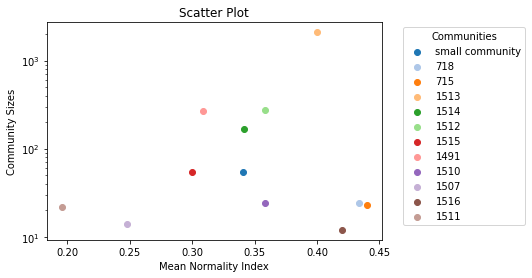

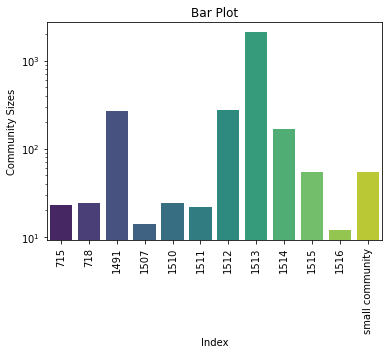

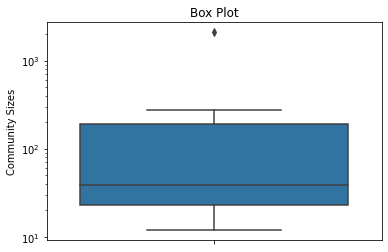

In [57]:

# Create a community for all students in communities with less than 2 students. Move all students in these communities to the new community.
# This is done to make the plot more readable.

# Get the number of students in each community
community_sizes = students_df['louvainId_pos_prop'].value_counts()

# Get the communities with less than 2 students
small_communities = community_sizes[community_sizes < 10]

# Create a new community for all students in the small communities
students_df.loc[students_df['louvainId_pos_prop'].isin(small_communities.index), 'louvainId_pos_prop'] = 'small community'

# Calculate the mean normalityIndex for each Louvain community
mean_normality_index = students_df.groupby('louvainId_pos_prop')['normalityIndex'].mean()

# Do a scatterplot where x-axis is the mean normalityIndex for the community and y-axis is the size of the community
# and color of the dot is the label of the community

community_sizes = students_df['louvainId_pos_prop'].value_counts()

louvain_communities_df = df({'mean_normality_index': mean_normality_index, 'community_sizes': community_sizes})

communities = students_df['louvainId_pos_prop'].unique()
colors = sns.color_palette("tab20", len(communities))
communities_color_map = dict(zip(communities, colors))


print(louvain_communities_df)



# Scatter plot
plt.figure()
for community, color in communities_color_map.items():
    subset = louvain_communities_df[louvain_communities_df.index == community]
    plt.scatter(subset['mean_normality_index'], subset['community_sizes'], c=[color], label=community)
plt.title('Scatter Plot')
plt.xlabel('Mean Normality Index')
plt.ylabel('Community Sizes')
plt.legend(title='Communities', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale('log')
plt.show()

# Bar plot
plt.figure()
sns.barplot(x=louvain_communities_df.index, y='community_sizes', data=louvain_communities_df, palette="viridis")
plt.title('Bar Plot')
plt.xlabel('Index')
plt.ylabel('Community Sizes')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

# Box plot
plt.figure()
sns.boxplot(y='community_sizes', data=louvain_communities_df)
plt.title('Box Plot')
plt.ylabel('Community Sizes')
plt.yscale('log')
plt.show()

